# Mask R-CNN - Train on Miami Buildings Dataset




In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
DATA_PATH = "/data/RCNNTanks256Train/Yanbu"

IMG_SIZE = 256

Using TensorFlow backend.


In [2]:
# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
import keras 

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

## Configurations

In [3]:
class MiamiConfig(Config):
    """Configuration for training on the Miami buildings dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Tank"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = IMG_SIZE
    IMAGE_MAX_DIM = IMG_SIZE

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  
    RPN_ANCHOR_SCALES = (10, 20, 40, 80, 160)  
    
    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
#     RPN_ANCHOR_RATIOS = [0.25, 1, 4]
    
    
    # Loss weights for more precise optimization.
    # Can be used for R-CNN training setup.
#     LOSS_WEIGHTS = {
#         "rpn_class_loss": 1.,
#         "rpn_bbox_loss": 1.,
#         "mrcnn_class_loss": 1.,
#         "mrcnn_bbox_loss": 1.,
#         "mrcnn_mask_loss": 1.1
#     }    

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 256
    
#     ROI_POSITIVE_RATIO = 0.5 #makes no positive effect

    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1
    
    # Image mean (RGB)
    MEAN_PIXEL = np.array([131.84381436753546, 125.43039054432134, 113.32320930217874]) 


    
config = MiamiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [131.84381437 125.4303

## Notebook Preferences

In [24]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax, fig

## Dataset

Load Miami dataset

Extend the Dataset class and add a method to load the dataset, `load()`, and override the following methods:

* load_mask()
* image_reference()

In [5]:
import glob
import skimage

class MiamiDataset(utils.Dataset):

    def load(self, dataset_dir):
        """
        Load a subset of the Miami dataset from the given dataset_dir.
        """
        
        # Add classes
        self.add_class("Tank", 1, "Tank")
        
        #loading images
        self._image_dir = os.path.join(dataset_dir, "images/")
        self._mask_dir = os.path.join(dataset_dir, "labels/")
        i=0
        for f in glob.glob(os.path.join(self._image_dir, "*.tif")):
            filename = os.path.split(f)[1]
            self.add_image("Tank", image_id=i, path=f,
                          width=config.IMAGE_MAX_DIM, height=config.IMAGE_MAX_DIM, filename=filename)
            i += 1
            
    def load_mask(self, image_id):
        """Read instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        fname = info["filename"]
        masks = []
        class_ids = []
        #looping through all the classes, loading and processing corresponding masks
        for ci in self.class_info:
            class_name = ci["name"]
            class_id = ci["id"]
            try:
                m_src = skimage.io.imread(os.path.join(self._mask_dir, class_name, fname))
            except:
                #no file with masks of this class found
                continue                
            #making individual masks for each instance
            instance_ids = np.unique(m_src)
            for i in instance_ids:
                if i > 0:
                    m = np.zeros(m_src.shape)
                    m[m_src==i] = i
                    if np.any(m==i):
                        masks.append(m)
                        class_ids.append(class_id)
        try:
            masks = np.stack(masks, axis=-1)        
        except:
            print("!!! no masks were found.", info)
            
        # Return mask, and array of class IDs of each instance.
        return masks.astype(np.bool), np.array(class_ids, dtype=np.int32)
        
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "miami":
            return info["miami"]
        else:
            super(self.__class__).image_reference(self, image_id)


In [6]:
# Training dataset
dataset_train = MiamiDataset()
dataset_train.load(os.path.join(DATA_PATH, "20150602_083117"))
dataset_train.prepare()

# Validation dataset
dataset_val = MiamiDataset()
dataset_val.load(os.path.join(DATA_PATH, "20151026_082156"))
dataset_val.prepare()

# Test dataset
dataset_test = MiamiDataset()
dataset_test.load(os.path.join(DATA_PATH, "20151226_085413"))
dataset_test.prepare()


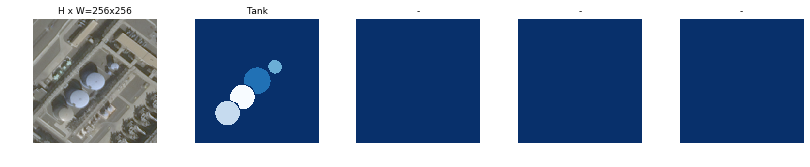

000000057.tif
mask                     shape: (256, 256, 4)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (4,)                  min:    1.00000  max:    1.00000  int32
[1 1 1 1]


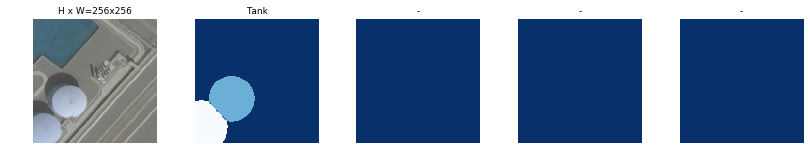

000000004.tif
mask                     shape: (256, 256, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
[1 1]


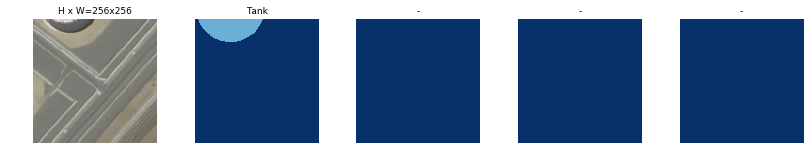

000000162.tif
mask                     shape: (256, 256, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
[1 1]


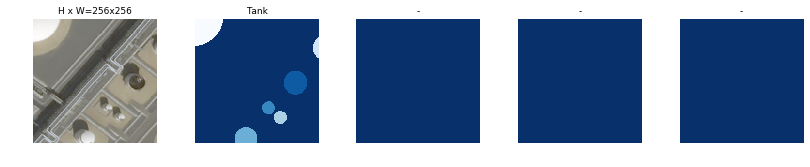

000000117.tif
mask                     shape: (256, 256, 6)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (6,)                  min:    1.00000  max:    1.00000  int32
[1 1 1 1 1 1]


In [7]:
# Load and display random samples
dataset = dataset_test
image_ids = np.random.choice(dataset.image_ids, 4)

# for ii in dataset.image_info:
#     if ii['filename'] == '000005160.tif':
#         image_ids = [ii['id']]
#         break

for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    print(dataset.image_info[image_id]["filename"])
    log("mask", mask)
    log("class_ids", class_ids)
    print(class_ids)


## Ceate Model

In [46]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training",
                          config=config,
                          model_dir=MODEL_DIR)

In [47]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model_path = model.find_last()[1]
#     model_path="/home/dkudinov/TF/VASYA/projects/RemoteSensing/BuildingDetection/projects/Miami/Mask_RCNN/logs/r5_imgaug_roi1000_20180608T1627/mask_rcnn_r5_imgaug_roi1000__0800.h5"
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)

Loading weights from  /home/dkudinov/TF/VASYA/projects/RemoteSensing/OilTanks/project/Mask_RCNN/logs/oil_1_20190502T1535/mask_rcnn_oil_1__0045.h5


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [48]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=90,
            layers='heads')


Starting at epoch 45. LR=0.0001

Checkpoint Path: /home/dkudinov/TF/VASYA/projects/RemoteSensing/OilTanks/project/Mask_RCNN/logs/oil_1_20190502T1535/mask_rcnn_oil_1__{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribute

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 46/90
 99/100 [============================>.] - ETA: 0s - loss: 0.1261 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.0905

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 72s 720ms/step - loss: 0.1259 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.0904 - val_loss: 1.1478 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.3264 - val_mrcnn_class_loss: 0.0091 - val_mrcnn_bbox_loss: 0.3143 - val_mrcnn_mask_loss: 0.4951
Epoch 47/90
100/100 [==============================] - 61s 613ms/step - loss: 0.1057 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0045 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0858 - val_loss: 1.5556 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 1.1069 - val_mrcnn_class_loss: 0.0224 - val_mrcnn_bbox_loss: 0.1504 - val_mrcnn_mask_loss: 0.2691
Epoch 48/90
100/100 [==============================] - 60s 601ms/step - loss: 0.1044 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0020 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0869 - val_loss: 1.6434 - val_rpn_class_loss

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)


## Detection

In [17]:
class InferenceConfig(MiamiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = model.find_last()[1]
# model_path = os.path.join(ROOT_DIR, "./logs/r5_imgaug_roi1000_20180608T1627/mask_rcnn_r5_imgaug_roi1000__0570.h5")

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/dkudinov/TF/VASYA/projects/RemoteSensing/OilTanks/project/Mask_RCNN/logs/oil_1_20190502T1535/mask_rcnn_oil_1__0045.h5


gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:    1.00000  bool
image_id:  35
{'height': 256, 'source': 'miami', 'filename': '000000144.tif', 'id': 35, 'width': 256, 'path': '/home/dkudinov/TF/VASYA/projects/RemoteSensing/OilTanks/data/RCNNTanks256Train/Yanbu/20151226_085413/images/000000144.tif'}
Processing 1 images
image                    shape: (256, 256, 3)         min:   29.00000  max:  237.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -84.32321  max:  123.67679  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.44367  max:    1.19269  float32
masks                    shape: (256, 256, 2)         min:    0.00000  max:    1.00000  bool
0.6666666865348816


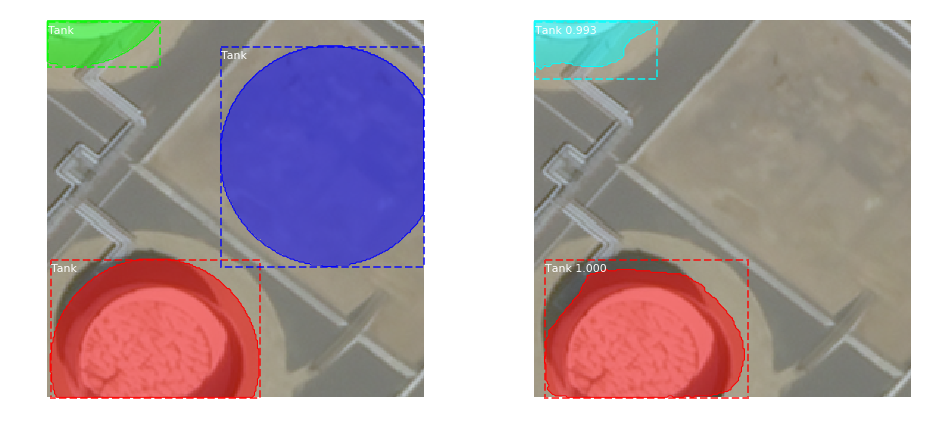

In [43]:
# Test on a random image
dataset = dataset_test

image_id = random.choice(dataset.image_ids)

# for ii in dataset.image_info:
#     if ii['filename'] == '000005160.tif':
#         image_id = ii['id']
#         break

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print("image_id: ", image_id)
print(dataset.image_info[image_id])

results = model.detect([original_image], verbose=1)
r = results[0]
if r["masks"].shape[2] > 0:
    log("masks", r["masks"])

ax, fig = get_ax(1,2)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=ax[0])
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax[1])
AP, precisions, recalls, overlaps =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'])
print(AP)    

In [44]:
fig.savefig("./tank8.png")

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
dataset = dataset_val
image_ids = dataset.image_ids
APs = []
pss = []
rcs = []
ops = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    pss.append(precisions)
    rcs.append(recalls)
    ops.append(overlaps)
    
print("mAP: ", np.mean(APs))

mAP:  0.44484031754480774


#### notes
- got to mAP:  0.45577036805483395 with /home/dkudinov/TF/VASYA/projects/RemoteSensing/BuildingDetection/projects/Miami/Mask_RCNN/logs/r2_mask1.1-miami20180425T1612/mask_rcnn_r2_mask1.1-miami_0446.h5

- keep training for another few hundred epochs (starting from 446 above), let's see if the mAP improves... after E403, the mAP:  0.469612436187523

- trainig further... after training for additional E76 (1000 steps x 10), no improvement -  mAP:  0.46841256759200284.

- let's train  ALL now... FineTuning didn't help - after E86 with LR/10 got to mAP: 0.46810221112934564 - no change at all.

- let's train with larger LR *= 10... - this one is unstable. Got NaNs at @E25+

- let's train with LR *= 5... - unstable either - NaNs after @E50

- training now LR *= 3, with balanced classes based on Round 2 + 3 + DSM (preserving Elevation), testing and validation with Round 3's corresponding sets... - training ALL does not take us much to good mAP: mAP: 0.23059609819186858 after E28 (mask_rcnn_r2_3-3xlr-balanced_classes_0003.h5). 

- let's train HEADS only for balanced classes and see if it works there with Transfer Learning... - doesn't produce good results.

- let's train with R2+R3 nDSM, different anchor ratios, 10..160 anchors. After E150 got mAP:  0.32985641013216305 on R3_Val (0.44688761373462743 on R3_test). Training further... Got additional E57 got 0.3452541601998945 on R3_Val (0.4490238384299554 on R3_Test)

- training now with ROIs set to 400 (instead of default 200). let's compare with previous run - should be better than 0.32985641013216305 on R3_Val (0.44688761373462743 on R3_test) after E150... The charts in general looks better: r2_3-anchratiosquarter-roi_40020180508T2227 than of previous run r2_3-anchratiosquarter20180504T1626, but have to stop now at E75 to evaluate and move on to another experiment. Results: 0.315 on R3_Val and 0.4259509508788332 on R3_test. Considerng the fact that result are slightly lower, but close at only half of the epochs and the charts look better in general, let's assume the TRAIN_ROIS_PER_IMAGE = 400 is worth keeping.

- training with ROUND_4 data: image sizes 320x320, pure nDSM in float32 format for 150 epochs. Let's compare against dmitry0 which runs the same settings (1000 steps, 4 images per GPU) test but with three channels (nDSM, SobelX, SobelY). If everything goes whell, results should be better than 0.32985641013216305 on R3_Val (0.44688761373462743 on R3_test) after E150 - 256x256 3channels (1000 step, 4 images per GPU). After E28 got 0.3213778065927779 on R3_val (0. 4393148630854612on R3_Test). Training further... on E051 got 0.320465666067902 on R3_Val (mAP:  0.44396389629254435 on R3_Test) - very little improvement. Switching back to 3 channels - looks like Dmitry0 got a better performance there, but is having overheating issues now.

- training with ROUND_4 data, image size 320x320, 3 channels (nDSM, SobelX, SobelY) for 150 epochs... at E87 got  0.34501237760069214 on R3_Val and 0.44482840372777777 on R3_Test.... how come it does not match DMITRY0 results?? after comparing detections on DMITRY0 and DMITRY00 on the same test images, DMITRY00 detections look better, although mAP is worse. higher mAP values on DMITRY0 may be driven by higher confidences returned by DMITRY0 NN... mAP is bad metric. Need to look for F1-score and IoU per class like deepglobe.org/challenge

- took the above r4-3channels-datafix-20180514T1531/mask_rcnn_r4-3channels-datafix-_0150.h5 which showed pretty decent results, and adding data augmentation... at E67 got mAP:  0.3734937277831339 on R3_Val (mAP:  0.46439362129382344 on R3_test). training further... after additional E84, got lower mAP:  0.3684524239513028 on R3_Val (0.46122923813690275 on R3_Test) - overfitting.

- training now with x3 zoom on the R4 training set: 960x960 tiles. After E400 (100 steps per epoch, 2 ims per gpu) got to 3.8+ on R3 Val, the chart keeps going down. Training now further with 1,000 steps per epoch... with additional E74 got to ***mAP:  0.42173135362633773 on R3_val*** - means we need to go to higher resolution for the nDSM to make smaller masks bigger.

- training with R5 now... trained for E370, but did not get above 0.34 on R5_val.

- increasing number of ROIs to 500, continuing training from previous experiments weights, but with SGD... got to 0.3576547253212615 on R5_val after short E30. training further with long (1,000 steps epochs)... trained for additional E29, got no imprvement: 0.3565351329501217.

- let's increase ROI even more, to 1,000. Training from last experiments weights... at E570, the mAP:  0.3542959663831263 on R5_val stays the same.... incresing LR from LR/10 to LR * 1... Got to ***mAP:  0.3648564952900007*** (mAP:  0.37188786173603927 on R5 Test) at E800.

- Let's try increasing ROI_POSITIVE_RATIO to 0.5. Since many buildings are not digitized, maybe it's better to reduce number of negatice examples, as they contribute to False Negatives?. Continuing from above E800... no progress.. continuing with LR x 3... - no improvement.

- let's start all over with R5_Kernel5 (maybe initial SobelXY kernel 3 was too fine-grained...)... mAP:  0.3487446665241425 at E465 - no much improvement over Kernel3.

##### R6 - same as R5 but withc much more samples (18,220; non QC'd masks are included)

- starting from scratch (imagenet)... on E266 got mAP:  0.44202111177251696 on R6_val (mAP:  0.3730775598715351 on R6_Test). training further, but with Validation and Test sets from R5 - maybe Tensorboard will work?...
- It is E634, we got 0.41887826709305165 on R5_Val (mAP:  0.5012143868593292 on R6_Val). For the sake of experiment, while VOLTA works with a smaller LR (LRx1), let's increase the LR here to LRx5 and see which will be effect of the Tensorboard, pure losses in particular. (E634 is the point of return)... progress stopped.
###### R6_LOG - will try using Log of color channel - let's see if it's going to help...
- Starting from IMAGENET. Training with DETECTION_MAX_INSTANCES = 250 and LOG of color channel, MEAN_PIXEL = np.array([78.0, 127.0, 127.0])... at E63 got mAP:  0.430829819719927 on R6Log_Val (mAP:  0.3621603452656377 R6Log_test)...


***Resizing input masks***

In [ ]:
#Resizing the input image and mask to make it bigger
from skimage.measure import find_contours, approximate_polygon, points_in_poly
from skimage.draw import polygon, polygon_perimeter

def normalize_float_img(img, img_min=None, img_max=None):
    #normalizing to range -1..1 so skimage.transform.resize can work
    if img_min is None:
        img_min = np.min(img)
        img_max = np.max(img)
    img_w = img_max - img_min
    img = np.copy(img)
    img -= img_min
    img = img * 2. / img_w - 1.
    return img

def normalize_to_uint8(img, img_min=None, img_max=None):
    if img_min is None:
        img_min = np.min(img)
        img_max = np.max(img)
    img_w = img_max - img_min
    img = np.copy(img)
    img -= img_min
    img *= 255. / img_w
    return img.astype(np.uint8)

def preprocess_input_img(img):
    img[img<0.] = 0. #not interested in any negative values, which may also include out-of-range -3.4028231e+38
    img_min = np.min(img)
    img_max = np.max(img)
    if img_min == img_max:
        #no-signal image
        return None
    
    img_sx = cv2.Sobel(np.copy(img),cv2.CV_64F,1,0,ksize=3) #derivative by X
    img_sy = cv2.Sobel(np.copy(img),cv2.CV_64F,0,1,ksize=3) #derivative by Y
    img = normalize_to_uint8(img, img_min=img_min, img_max=img_max)
    img_sx = normalize_to_uint8(img_sx)
    img_sy = normalize_to_uint8(img_sy)
    img = np.stack([img, img_sx, img_sy], axis=2)
    return img

def resize_mask(mask, coef):
    #resizing mask using bilinear interpolation
    mask_ids = np.unique(mask)
    img_size = mask.shape[0]
    res_size = img_size*coef
    res_img = np.zeros((res_size, res_size), dtype=np.int32)
    for mi in mask_ids:
        if mi != 0:
            padded_mask = np.zeros((img_size + 2,img_size + 2), dtype=np.uint32)
            padded_mask[1:-1, 1:-1] = mask
            padded_mask[padded_mask!=mi] = 0
            contours = find_contours(padded_mask, 0.5, fully_connected='high')    
            prev_contour = []
            for contour in contours:
                verts = (contour - 0.5)*coef
                a_verts = approximate_polygon(verts, coef/2.) #RDP simplification
                r = a_verts[:,0]
                r[r>=res_size] = res_size-1
                c = a_verts[:,1]
                c[c>=res_size] = res_size-1
                rrp, ccp = polygon(r,c)
                if len(prev_contour) > 0 and points_in_poly([a_verts[0]], prev_contour):
                    #this is a contour of a hole of the max_contour. We'll keep it around.
                    res_img[rrp,ccp] = 0
                else:
                    #this is a true mask
                    res_img[rrp,ccp] = mi                   
                prev_contour = a_verts
    return res_img

def resize_image(img, coef):
    img_size = img.shape[0]
    res_size = img_size*coef
    img = normalize_float_img(img)
    res_img = skimage.transform.resize(img, (res_size, res_size), preserve_range=True, order=1)
    return res_img.astype(np.float32) + 1.0

In [ ]:
from skimage.external.tifffile import imsave


img = skimage.io.imread('/home/dkudinov/TF/VASYA/data/SemanticSegmentation/Dan_H_3Dteam/Miami/TrainingData_Miami/Miami_Round_4_raw/val/nDSM/images/000000266.tif')
res_img = resize_image(img, 3)
res_img = preprocess_input_img(res_img)
imsave('/home/dkudinov/TF/VASYA/tmp/000000266.tif', res_img, compress=9)
img2 = skimage.io.imread('/home/dkudinov/TF/VASYA/tmp/000000266.tif')

msk = skimage.io.imread('/home/dkudinov/TF/VASYA/data/SemanticSegmentation/Dan_H_3Dteam/Miami/TrainingData_Miami/Miami_Round_4_raw/val/masks/gable/000000266.tif')
res_msk = resize_mask(msk, 3)
imsave('/home/dkudinov/TF/VASYA/tmp/000000266-gable.tif', res_msk, compress=9)
msk2 = skimage.io.imread('/home/dkudinov/TF/VASYA/tmp/000000266-gable.tif')

visualize.display_images([img, img2, msk, msk2],cols=2)



In [ ]:
img = skimage.io.imread('/home/dkudinov/TF/VASYA/data/SemanticSegmentation/Dan_H_3Dteam/Miami/TrainingData_Miami/Miami_Round_4_x2/Testing/images/000067362.tif')
msk = skimage.io.imread('/home/dkudinov/TF/VASYA/data/SemanticSegmentation/Dan_H_3Dteam/Miami/TrainingData_Miami/Miami_Round_4_x2/Testing/masks/gable/000067362.tif')
visualize.display_images([img, msk],cols=2)


***temp***

In [28]:
def normalize_to_uint8(img):
    i_min = np.min(img)
    i_max = np.max(img)
    i_w = i_max - i_min
    img = np.copy(img)
    img -= i_min
    img *= 255. / i_w
    return img.astype(np.uint8)



[-0.14734201  0.          0.         21.2190609  86.42774963]
[0.         0.13744794 0.13744794 3.10755997 4.47249651]


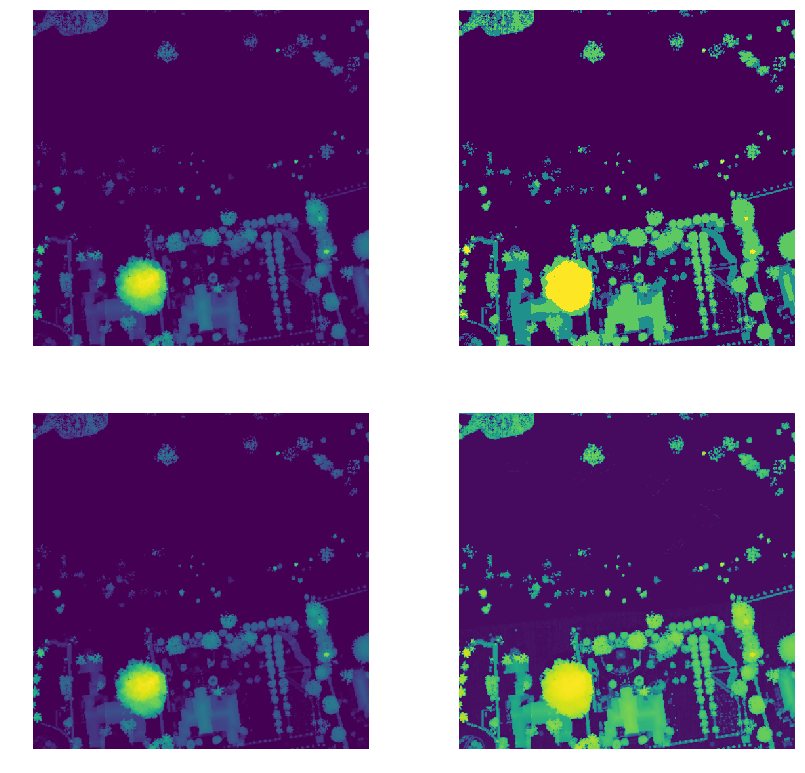

In [35]:
#can a log of color channel improve the semantics of training data?
#experiemnting for building MIAMI_ROUND_6_LOG dataset...

img = skimage.io.imread('/home/dkudinov/TF/VASYA/data/SemanticSegmentation/Dan_H_3Dteam/Miami/TrainingData_Miami/Miami_Round_6_raw/val/images/000004236.tif')

q = [0,10,50,90,100]
pctl = np.percentile(img, q)
print(pctl)
log_img = np.log(img - pctl[0] + 1.0)
log_pctl = np.percentile(log_img, q)
print(log_pctl)

visualize.display_images([img, log_img,
                         normalize_to_uint8(img), normalize_to_uint8(log_img)], cols=2)


***checking the interator - is there a problem in data why it crashes?***

In [ ]:
dataset = dataset_train
image_ids = dataset.image_ids
min_m = 1000
max_m = 0
for image_id in image_ids:
    image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
        modellib.load_image_gt(dataset, config, image_id, augment=False,
                      augmentation=None,
                      use_mini_mask=True)
    min_m = np.min([min_m, gt_boxes.shape[0]])
    max_m = np.max([max_m, gt_boxes.shape[0]])
#     break
print(min_m, max_m)

In [27]:
print(min_m, max_m)

1 639


In [8]:
import imgaug as ia
from imgaug import augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seqAug = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 20% of all images
        # crop images by -10% to 10% of their height/width
#         sometimes(iaa.CropAndPad(
#             percent=(-0.1, 0.1),
#             pad_mode=ia.ALL,
#             pad_cval=0
#         )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-175, 175), # rotate by -175 to +175 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval = 0
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
    ],
    random_order=True
)
train_generator = modellib.data_generator(dataset_train, config, shuffle=True,
                                 augmentation=seqAug,
                                 batch_size=config.BATCH_SIZE)

In [ ]:
while True:
    next(train_generator)